# Lab 4
by Bjørn Christian Weinbach

## Problem 1

### Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
sys.path.append("..") # Adds higher directory to python modules path.
import pdffuns

### Read data

In [2]:
pfile = 'lab4.p'
with open(pfile, "rb") as fp:
    Test, Train = pickle.load(fp)

In [3]:
Train_omega1, Train_omega2, Test_omega1, Test_omega2 = Train[0], Train[1], Test[0], Test[1]

### Plot training data

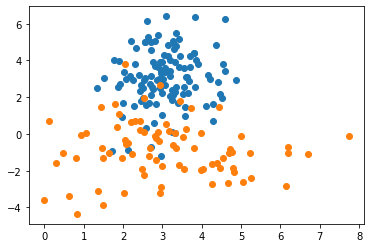

In [4]:
plt.scatter(Train_omega1[0], Train_omega1[1])
plt.scatter(Train_omega2[0], Train_omega2[1])

### Plot test data

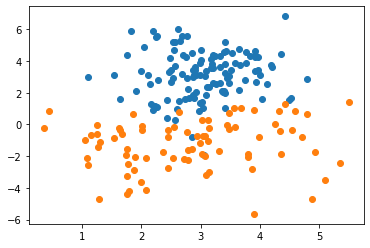

In [5]:
plt.scatter(Test_omega1[0], Test_omega1[1])
plt.scatter(Test_omega2[0], Test_omega2[1])

### Construct dataframe

#### training dataset

In [6]:
train = pd.DataFrame({'x1': list(Train_omega1[0]), 'x2': list(Train_omega1[1]), 'class': list(np.zeros(len(Train_omega1[1])))})
train = train.append(pd.DataFrame({'x1': list(Train_omega2[0]), 'x2': list(Train_omega2[1]), 'class': list(np.ones(len(Train_omega2[0])))}))
train = train.reset_index(drop=True)

#### test dataset

In [7]:
test = pd.DataFrame({'x1': list(Test_omega1[0]), 'x2': list(Test_omega1[1]), 'class': list(np.zeros(len(Test_omega1[1])))})
test = test.append(pd.DataFrame({'x1': list(Test_omega2[0]), 'x2': list(Test_omega2[1]), 'class': list(np.ones(len(Test_omega2[1])))}))
test = test.reset_index(drop=True)

### Classify test-data

Using classify method in pdffuns. It returns the classifications and function values.
This method works for any dimension.

In [8]:
classpred_test, funcval_test = pdffuns.classifyML(train, test)

### Reclassify train-data

In [9]:
classpred_train, funcval_train = pdffuns.classifyML(train, train)

### Reclassification confusion matrix

In [10]:
reclassification_cm = confusion_matrix(np.array(train['class']), classpred_train)

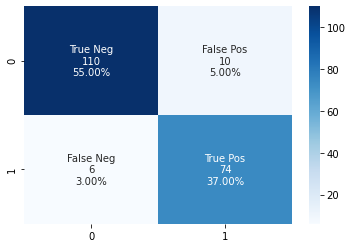

In [11]:
def confusionMatrix(cfm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cfm.flatten()/np.sum(cfm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues')

confusionMatrix(reclassification_cm)

### Test confusion matrix

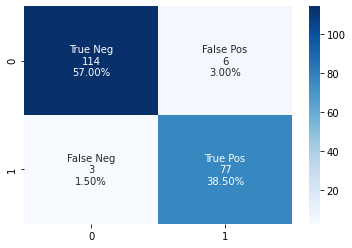

In [12]:
test_cm = confusion_matrix(np.array(test['class']), classpred_test)
confusionMatrix(test_cm)

### Performance metrics

In [13]:
def recall(confusionMatrix, correct):
    return confusionMatrix[correct, correct] / sum(confusionMatrix[correct, :])

def precision(confusionMatrix, correct):
    return confusionMatrix[correct, correct] / sum(confusionMatrix[:, correct])

def accuracy(confusionMatrix):
    return (confusionMatrix.trace()) / sum(confusionMatrix.flatten())

### Calculate metrics for reclassification

In [14]:
def metrics(confusionMatrix, dim):
    print("Error: " + str(1 - accuracy(confusionMatrix)))
    for i in range(dim):
        print("P(correct|{}) ".format(str(i)) + str(recall(confusionMatrix, i)))

### Calculate metrics for test

In [15]:
metrics(test_cm, len(test_cm))

Error: 0.04500000000000004
P(correct|0) 0.95
P(correct|1) 0.9625


### Parzen-classifier with $\Delta = 0.5$ and $h_1=0.1$

My implementation evaluates the density for a grid of points from the minimum to maximum values of feature 1 and 2. 
This classifier becomes increasingly computationally demanding, especially if the range is large and $h_1$ is small since this forces us to decrease $\Delta$ (step size) in the computation points.

#### Reclassification

In [16]:
parzen_classpred_train = pdffuns.classifyParzen(train, train, window=0.1, delta=0.1)

#### Reclassification confusion matrix

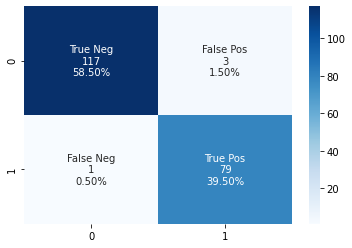

In [17]:
parzen_train_cm = confusion_matrix(np.array(train['class']), parzen_classpred_train)
confusionMatrix(parzen_train_cm)

In [18]:
metrics(parzen_train_cm, len(parzen_train_cm))

Error: 0.020000000000000018
P(correct|0) 0.975
P(correct|1) 0.9875


#### Test

In [19]:
parzen_classpred_test = pdffuns.classifyParzen(train, test, window=0.1, delta=0.5)

#### Test confusion matrix

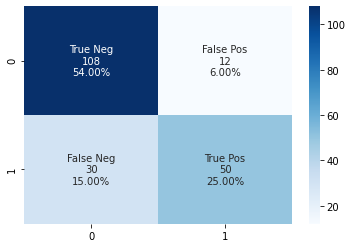

In [20]:
parzen_test_cm = confusion_matrix(np.array(test['class']), parzen_classpred_test)
confusionMatrix(parzen_test_cm)

In [21]:
metrics(parzen_test_cm, len(parzen_test_cm))

Error: 0.20999999999999996
P(correct|0) 0.9
P(correct|1) 0.625


### Parzen-classifier with $\Delta = 0.5$ and $h_1=5$

#### Reclassification

In [22]:
parzen2_classpred_train = pdffuns.classifyParzen(train, train, window=5, delta=0.1)

#### Confusion matrix - reclassificaton

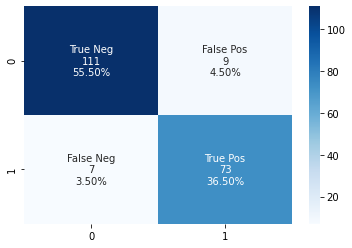

In [23]:
parzen2_train_cm = confusion_matrix(np.array(train['class']), parzen2_classpred_train)
confusionMatrix(parzen2_train_cm)

In [24]:
metrics(parzen2_train_cm, len(parzen2_train_cm))

Error: 0.07999999999999996
P(correct|0) 0.925
P(correct|1) 0.9125


#### Test

In [25]:
parzen2_classpred_test = pdffuns.classifyParzen(train, test, window=5, delta=0.1)

#### Test confusion matrix

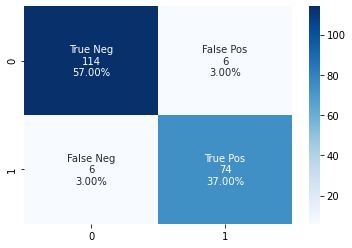

In [26]:
parzen2_test_cm = confusion_matrix(np.array(test['class']), parzen2_classpred_test)
confusionMatrix(parzen2_test_cm)

In [27]:
metrics(parzen2_test_cm, len(parzen2_test_cm))

Error: 0.06000000000000005
P(correct|0) 0.95
P(correct|1) 0.925


#### Discussion on findings.

What we see when using a $h_1$ that is low is that the estimated density from the training data is failing to generalise.
This is most clearly seen by the high reclassification score and low testing score. What has happened here is that the model fails to capture the general distribution and instead estimate a density that is very accurate for the training data but not in general. I.e, a classic example of overfitting.

This is due to the low $h_1$ value. We recall from the lectures that Parzen-Window estimates the density by summing gaussian kernels for all the samples yielding a estimate for the underlying distribution. When $h_1$ is low, the variance of the gaussian kernel is low and has high values very close to the point. This means that we have a distribution that has very high values in points similar to the training data yielding poor results in the test data.

### Nearest neighbor $k_n=1$

#### Reclassification

In [28]:
knn1_classpred_train = pdffuns.knnClassifier(train, train, k=1)

#### Confusion Matrix

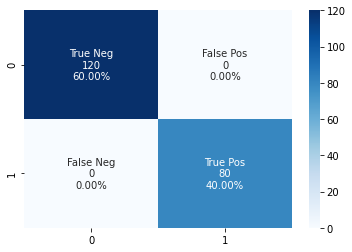

In [29]:
knn1_train_cm = confusion_matrix(np.array(train['class']), knn1_classpred_train)
confusionMatrix(knn1_train_cm)

In [30]:
metrics(knn1_train_cm, len(knn1_train_cm))

Error: 0.0
P(correct|0) 1.0
P(correct|1) 1.0


#### Test

In [31]:
knn1_classpred_test = pdffuns.knnClassifier(train, test, k=1)

#### Test confusion matrix

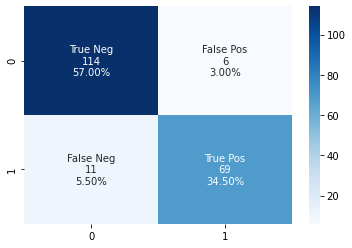

In [32]:
knn1_test_cm = confusion_matrix(np.array(test['class']), knn1_classpred_test)
confusionMatrix(knn1_test_cm)

In [33]:
metrics(knn1_test_cm, len(knn1_test_cm))

Error: 0.08499999999999996
P(correct|0) 0.95
P(correct|1) 0.8625


#### Discussion on findings

When $k=1$, the nearest neighbor will always be the point itself and it will be classified as the same class as itself.
That is the reason for the low error and high recall. When classifying the test data we get an error rate of $0.08$ and the recall falls a bit. Our model has therefore not been able to generalise.

### Nearest neighbor $k_n=5$

#### Reclassification

In [34]:
knn5_classpred_train = pdffuns.knnClassifier(train, train, k=5)

#### Reclassification confusion matrix

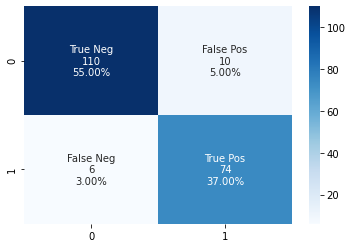

In [35]:
knn5_train_cm = confusion_matrix(np.array(train['class']), knn5_classpred_train)
confusionMatrix(knn5_train_cm)

In [36]:
metrics(knn5_train_cm, len(knn5_train_cm))

Error: 0.07999999999999996
P(correct|0) 0.9166666666666666
P(correct|1) 0.925


#### Test

In [37]:
knn5_classpred_test = pdffuns.knnClassifier(train, test, k=5)

#### Test confusion matrix

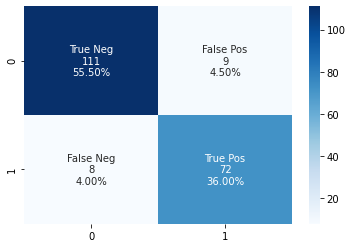

In [38]:
knn5_test_cm = confusion_matrix(np.array(test['class']), knn5_classpred_test)
confusionMatrix(knn5_test_cm)

In [39]:
metrics(knn5_test_cm, len(knn5_test_cm))

Error: 0.08499999999999996
P(correct|0) 0.925
P(correct|1) 0.9


#### Discussion on findings

In the $k=5$ case, we observe that reclassification and test confusion matrix and performance metrics are quite similar. Our model has therefore been able to generalise.

## Problem 2

### Read Data

In [40]:
pfile = 'lab4_2.p'
with open(pfile, "rb") as fp:
    (X_2D3cl, X_2D4cl, X_2D4cl_ms, X_2D4cl_hs, 
    X_3D3cl_ms, Y_2D3cl, Y_2D4cl, Y_2D4cl_ms, 
    Y_2D4cl_hs, Y_3D3cl_ms) = pickle.load(fp)

### 2D Features - 3 class problem

#### Read Data

In [41]:
Train_omega1, Train_omega2, Train_omega3 = Y_2D3cl[0], Y_2D3cl[1], Y_2D3cl[2]
Test_omega1, Test_omega2, Test_omega3 = X_2D3cl[0], X_2D3cl[1], X_2D3cl[2]

#### Scatterplot of training data

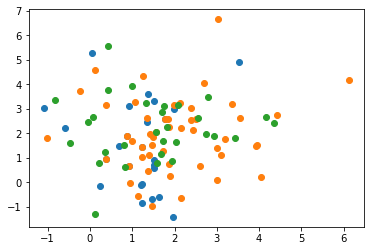

In [42]:
plt.scatter(Train_omega1[0], Train_omega1[1])
plt.scatter(Train_omega2[0], Train_omega2[1])
plt.scatter(Train_omega3[0], Train_omega3[1])

#### Scatterplot of test data

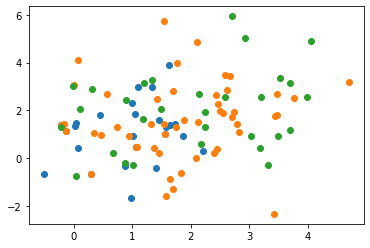

In [43]:
plt.scatter(Test_omega1[0], Test_omega1[1])
plt.scatter(Test_omega2[0], Test_omega2[1])
plt.scatter(Test_omega3[0], Test_omega3[1])

#### Construct dataframes

In [44]:
train = pd.DataFrame(
    {'x1': list(Train_omega1[0]),
     'x2': list(Train_omega1[1]),
     'class': list(np.zeros(len(Train_omega1[1])))}
    )

train = train.append(
    pd.DataFrame({'x1': list(Train_omega2[0]), 'x2': list(Train_omega2[1]), 'class': list(np.ones(len(Train_omega2[0])))})
    )

train = train.reset_index(drop=True)

train = train.append(
    pd.DataFrame(
        {'x1': list(Train_omega3[0]), 
         'x2': list(Train_omega3[1]), 
         'class': list(np.ones(len(Train_omega3[0]))*2)}
         )
    )

train = train.reset_index(drop=True)

test = pd.DataFrame(
    {'x1': list(Test_omega1[0]), 
     'x2': list(Test_omega1[1]), 
     'class': list(np.zeros(len(Test_omega1[1])))}
    )

test = test.append(
    pd.DataFrame(
        {'x1': list(Test_omega2[0]), 
         'x2': list(Test_omega2[1]), 
         'class': list(np.ones(len(Test_omega2[1])))})
    )

test = test.reset_index(drop=True)

test = test.append(
    pd.DataFrame(
        {'x1': list(Test_omega3[0]), 
         'x2': list(Test_omega3[1]), 
         'class': list(np.ones(len(Test_omega3[1]))*2)})
    )

test = test.reset_index(drop=True)

#### Reclassify ML

In [45]:
classpred_2d3cl_train, _ = pdffuns.classifyML(train, train)
classpred_2d3cl_train_cm = confusion_matrix(np.array(train['class']), classpred_2d3cl_train)
metrics(classpred_2d3cl_train_cm, len(classpred_2d3cl_train_cm))

Error: 0.5714285714285714
P(correct|0) 0.64
P(correct|1) 0.36
P(correct|2) 0.36666666666666664


#### Test ML

In [46]:
classpred_2d3cl_test, _ = pdffuns.classifyML(train, test)
classpred_2d3cl_test_cm = confusion_matrix(np.array(test['class']), classpred_2d3cl_test)
metrics(classpred_2d3cl_test_cm, len(classpred_2d3cl_test_cm))

Error: 0.5238095238095238
P(correct|0) 0.8
P(correct|1) 0.42
P(correct|2) 0.3


#### Reclassify Parzen with $h_1 = 0.1

In [47]:
parzen_classpred_2d3cl_train = pdffuns.classifyParzen(train, train, window=0.1, delta=0.1)

#### Confusion matrix reclassification

In [48]:
parzen_classpred_2d3cl_train_cm = confusion_matrix(np.array(train['class']), parzen_classpred_2d3cl_train)
metrics(parzen_classpred_2d3cl_train_cm, len(parzen_classpred_2d3cl_train_cm))

Error: 0.05714285714285716
P(correct|0) 0.92
P(correct|1) 0.92
P(correct|2) 1.0


#### Test Parzen with $h_1 = 0.1

In [49]:
parzen_classpred_2d3cl_test = pdffuns.classifyParzen(train, test, window=0.1, delta=0.1)

#### Test Confusion matrix

In [50]:
parzen_classpred_2d3cl_test_cm = confusion_matrix(np.array(test['class']), parzen_classpred_2d3cl_test)
metrics(parzen_classpred_2d3cl_test_cm, len(parzen_classpred_2d3cl_test_cm))

Error: 0.6666666666666667
P(correct|0) 0.48
P(correct|1) 0.24
P(correct|2) 0.36666666666666664


#### Reclassify Parzen with $h_1 = 5

In [51]:
parzen_classpred_2d3cl_train = pdffuns.classifyParzen(train, train, window=5, delta=0.1)

#### Confusion matrix reclassification

In [52]:
parzen_classpred_2d3cl_train_cm = confusion_matrix(np.array(train['class']), parzen_classpred_2d3cl_train)
metrics(parzen_classpred_2d3cl_train_cm, len(parzen_classpred_2d3cl_train_cm))

Error: 0.4571428571428572
P(correct|0) 0.16
P(correct|1) 0.96
P(correct|2) 0.16666666666666666


#### Test Parzen with $h_1 = 5

In [53]:
parzen_classpred_2d3cl_test = pdffuns.classifyParzen(train, test, window=5, delta=0.1)

#### Test Confusion matrix

In [54]:
parzen_classpred_2d3cl_test_cm = confusion_matrix(np.array(test['class']), parzen_classpred_2d3cl_test)
metrics(parzen_classpred_2d3cl_test_cm, len(parzen_classpred_2d3cl_test_cm))

Error: 0.5333333333333333
P(correct|0) 0.16
P(correct|1) 0.82
P(correct|2) 0.13333333333333333


#### Reclassify Knn with $K = 1$

In [55]:
knn1_classpred_2d3cl_train = pdffuns.knnClassifier(train, train, k=1)

#### Reclassification confusion matrix

In [56]:
knn1_classpred_2d3cl_train_cm = confusion_matrix(np.array(train['class']), knn1_classpred_2d3cl_train)
metrics(knn1_classpred_2d3cl_train_cm, len(knn1_classpred_2d3cl_train_cm))

Error: 0.04761904761904767
P(correct|0) 0.96
P(correct|1) 0.92
P(correct|2) 1.0


#### Test Knn with $K = 1$

In [57]:
knn1_classpred_2d3cl_test = pdffuns.knnClassifier(train, test, k=1)

#### Test confusion matrix

In [58]:
knn1_classpred_2d3cl_test_cm = confusion_matrix(np.array(test['class']), knn1_classpred_2d3cl_test)
metrics(knn1_classpred_2d3cl_test_cm, len(knn1_classpred_2d3cl_test_cm))

Error: 0.638095238095238
P(correct|0) 0.28
P(correct|1) 0.44
P(correct|2) 0.3


#### Reclassify Knn with $K = 5$

In [59]:
knn5_classpred_2d3cl_train = pdffuns.knnClassifier(train, train, k=5)

#### Reclassification confusion matrix

In [60]:
knn5_classpred_2d3cl_train_cm = confusion_matrix(np.array(train['class']), knn5_classpred_2d3cl_train)
metrics(knn5_classpred_2d3cl_train_cm, len(knn5_classpred_2d3cl_train_cm))

Error: 0.48571428571428577
P(correct|0) 0.56
P(correct|1) 0.58
P(correct|2) 0.36666666666666664


#### Test Knn with $K = 5$

In [61]:
knn5_classpred_2d3cl_test = pdffuns.knnClassifier(train, test, k=5)

#### Test confusion matrix

In [62]:
knn5_classpred_2d3cl_test_cm = confusion_matrix(np.array(test['class']), knn5_classpred_2d3cl_test)
metrics(knn5_classpred_2d3cl_test_cm, len(knn5_classpred_2d3cl_test_cm))

Error: 0.6285714285714286
P(correct|0) 0.44
P(correct|1) 0.46
P(correct|2) 0.16666666666666666
